In [1]:
import os
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import DataStructs
from massspecgym.data.datasets import MassSpecDataset, MSnDataset
from massspecgym.data.data_module import MassSpecDataModule
from massspecgym.data.transforms import MolFingerprinter
from massspecgym.utils import (
    morgan_fp, init_plotting, parse_paths_from_df, find_duplicate_smiles, add_identifiers, 
    visualize_MSn_tree, smiles_to_scaffold, train_val_test_split, create_split_file
    )
%reload_ext autoreload
%autoreload 2

In [2]:
datasets_paths = ["../../data/MSn/20231031_nihnp_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20231130_mcescaf_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20231130_otavapep_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20240411_mcebio_library_pos_all_lib_MSn.mgf"]

In [3]:
# merge datasets into a single mgf file
if os.path.exists("../../data/MSn/all_MSn_spectra.mgf"):
    print("merged mgf file already exists in data/MSn/all_MSn_spectra.mgf")
else:
    with open("../../data/MSn/all_MSn_spectra.mgf", "w") as outfile:
        for dataset_path in datasets_paths:
            print(dataset_path)
            with open(dataset_path, "r") as infile:
                for line in infile:
                    outfile.write(line)
                infile.close()
    print("merged mgf file was successfully created in data/MSn/all_MSn_spectra.mgf")

merged mgf file already exists in data/MSn/all_MSn_spectra.mgf


In [41]:
#msn_dataset = MSnDataset(pth="../../data/MSn/all_MSn_spectra.mgf", mol_transform=MolFingerprinter)
msn_dataset = MSnDataset(pth="../../data/MSn/debug.mgf", mol_transform=MolFingerprinter.from_smiles)
print(len(msn_dataset))

956


In [42]:
msn_dataset[0]

TypeError: MolFingerprinter.from_smiles() missing 1 required positional argument: 'mol'

In [27]:
msn_dataset.metadata.to_csv("../../data/MSn/all_MSn_spectra.csv")

In [28]:
metadata_df = pd.read_csv("../../data/MSn/all_MSn_spectra.csv")
correct_number_of_trees = 0  # number of occurances of "ms_level" == 2
for ms_level, precursor_mz in zip(metadata_df["ms_level"], metadata_df["precursor_mz"]):
    if int(ms_level) == 2:
        correct_number_of_trees += 1
print("Correct number of MSn trees:", correct_number_of_trees)

Correct number of MSn trees: 956


In [29]:
all_smiles = [smi for smi in [msn_dict["mol"] for msn_dict in msn_dataset]]
scaffolds = [smiles_to_scaffold(smi) for smi in all_smiles]
print(len(all_smiles))

956


In [30]:
train, validation, test = train_val_test_split(all_smiles, scaffolds)
print(len(train), len(validation), len(test))
print(len(train)+len(validation)+len(test), len(all_smiles))

764 96 96
956 956


In [31]:
tanimoto_df = pd.DataFrame(columns=["identifier", "fold"])
split_smiles = [
    ("train", [all_smiles[i] for i in train]), 
    ("val", [all_smiles[i] for i in validation]),
    ("test", [all_smiles[i] for i in test])
    ]

rows = []
# create the dataframe row by row
for fold, fold_smiles in split_smiles:
    for smi in fold_smiles:
        rows.append({"smiles": smi, "fold": fold})

# concatenate the rows into the dataframe
tanimoto_df = pd.concat([tanimoto_df, pd.DataFrame(rows)], ignore_index=True)

fps = {}
for fold in ['train', 'val', 'test']:
    print(fold)
    df_fold = tanimoto_df[tanimoto_df['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: morgan_fp(Chem.MolFromSmiles(s), to_np=False))

def max_tanimoto(target_fp, comparison_fps):
    return np.max([DataStructs.FingerprintSimilarity(target_fp, comparison_fp) for comparison_fp in comparison_fps])

train


100%|██████████| 562/562 [00:00<00:00, 2443.03it/s]


val


100%|██████████| 69/69 [00:00<00:00, 3104.93it/s]


test


100%|██████████| 66/66 [00:00<00:00, 2809.43it/s]


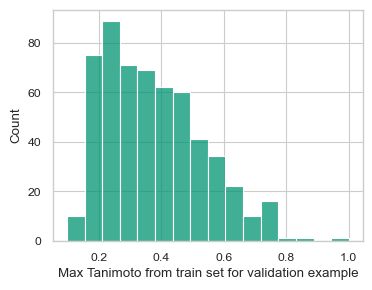

In [32]:
# Tanimoto similarity between train and validation molecules
max_train_tanimotos = []
for train_fp in fps['train']:
    max_train_tanimotos.append(max_tanimoto(train_fp, fps["val"]))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

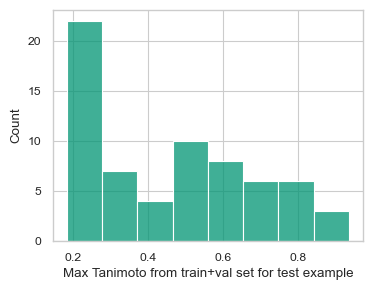

In [33]:
# tanimoto similarity between train+validation and test molecules
train_val_fps = pd.concat([pd.Series(fps['train']), pd.Series(fps['val'])])

max_train_tanimotos = []
for test_fp in fps['test']:
    max_train_tanimotos.append(max_tanimoto(test_fp, train_val_fps))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

In [34]:
split_tsv_path = "../../data/MSn/MSn_splits.tsv"
create_split_file(msn_dataset, train, validation, test, split_tsv_path)

split tsv file already exists at ../../data/MSn/MSn_splits.tsv


In [35]:
mspec_data_module = MassSpecDataModule(batch_size=2, dataset=msn_dataset, split_pth="../../data/MSn/MSn_splits.tsv")
mspec_data_module.prepare_data()
mspec_data_module.setup()
mspec_data_module.train_dataloader()
mspec_data_module.val_dataloader()

In [37]:
foo = mspec_data_module.val_dataloader()
next(iter(foo))

{'spec_tree': DataBatch(x=[0, 1], edge_index=[0], batch=[0], ptr=[3]),
 'mol': ['C=C(CCO)C(=O)OCC1OCC(OC(=O)C(=C)CCO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)C(O)C1O',
  'C=C(CCO)C(=O)OCC1OCC(OC(=O)C(=C)CCO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)C(O)C1O']}

In [17]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from massspecgym.data import RetrievalDataset, MassSpecDataModule
from massspecgym.data.transforms import SpecTokenizer, MolFingerprinter
from massspecgym.models.base import Stage
from massspecgym.models.retrieval.base import RetrievalMassSpecGymModel

In [18]:
class MyDeepSetsRetrievalModel(RetrievalMassSpecGymModel):
    def __init__(
        self,
        hidden_channels: int = 512,
        out_channels: int = 4096,  # fingerprint size
        *args,
        **kwargs
    ):
        """Implement your architecture."""
        super().__init__(*args, **kwargs)

        self.phi = nn.Sequential(
            nn.Linear(2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement your prediction logic."""
        x = self.phi(x)
        x = x.sum(dim=-2)  # sum over peaks
        x = self.rho(x)
        return x

    def step(
        self, batch: dict, stage: Stage
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Implement your custom logic of using predictions for training and inference."""
        # Unpack inputs
        x = batch["spec_tree"]  # input spectra
        fp_true = batch["mol"]  # true fingerprints
        # cands = batch["candidates"]  # candidate fingerprints concatenated for a batch
        # batch_ptr = batch["batch_ptr"]  # number of candidates per sample in a batch

        # Predict fingerprint
        fp_pred = self.forward(x)

        # Calculate loss
        loss = nn.functional.mse_loss(fp_true, fp_pred)

        # Calculate final similarity scores between predicted fingerprints and retrieval candidates
        # fp_pred_repeated = fp_pred.repeat_interleave(batch_ptr, dim=0)
        # scores = nn.functional.cosine_similarity(fp_pred_repeated, cands)

        # return dict(loss=loss, scores=scores)
        return dict(loss=loss, scores=None)

In [20]:
# Init hyperparameters
fp_size = 4096

# Init data module
data_module = mspec_data_module

# Init model
model = MyDeepSetsRetrievalModel(out_channels=fp_size)

# Init trainer
trainer = Trainer(accelerator="cpu", devices=1)

# Train
trainer.fit(model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Lukas\anaconda3\envs\massspecgym\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Lukas\anaconda3\envs\massspecgym\Lib\site-packages\pytorch_lightning\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 264 K  | train
1 | rho  | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Lukas\anaconda3\envs\massspecgym\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataBatch